In [1]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection, Sam2Processor, Sam2Model
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GroundingDINO for text-to-bounding-box
gd_processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-tiny")
gd_model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-tiny").to(device)

# SAM 2 for segmentation
sam_processor = Sam2Processor.from_pretrained("facebook/sam2.1-hiera-large")
sam_model = Sam2Model.from_pretrained("facebook/sam2.1-hiera-large").to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/898M [00:00<?, ?B/s]

Saving testimg1.jpg to testimg1.jpg


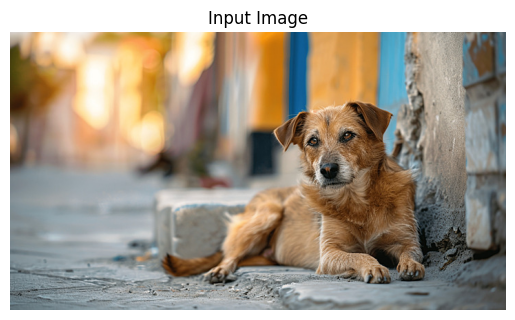

Enter text prompt for segmentation: dog
Prompt: "dog"


In [3]:
# Upload an image file
uploaded = files.upload()  # Use Colab file upload
image_path = next(iter(uploaded))  # get uploaded file name
image = Image.open(image_path).convert("RGB")
plt.imshow(image); plt.axis('off'); plt.title("Input Image"); plt.show()

# Enter text prompt
prompt = input("Enter text prompt for segmentation: ")
print(f"Prompt: \"{prompt}\"")

In [4]:
# Prepare inputs for GroundingDINO
inputs = gd_processor(images=image, text=[[prompt]], return_tensors="pt").to(device)
with torch.no_grad():
    outputs = gd_model(**inputs)

# Post-process to get bounding boxes above thresholds
results = gd_processor.post_process_grounded_object_detection(
    outputs, inputs.input_ids, threshold=0.35, text_threshold=0.25, target_sizes=[image.size[::-1]]
)
boxes = []
for result in results:
    for box in result["boxes"]:
        # Convert box to [x_min, y_min, x_max, y_max] integers
        x0, y0, x1, y1 = box.tolist()
        x0, y0 = max(0, int(x0)), max(0, int(y0))
        x1, y1 = min(image.width, int(x1)), min(image.height, int(y1))
        boxes.append([x0, y0, x1, y1])
print("Generated boxes:", boxes)


Generated boxes: [[218, 100, 603, 367]]


In [5]:
if not boxes:
    print("No bounding boxes found for the given prompt.")
else:
    # Prepare inputs for SAM 2 with bounding boxes
    inputs_sam = sam_processor(images=image, input_boxes=[boxes], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs_sam = sam_model(**inputs_sam, multimask_output=False)
    # Retrieve mask (one mask per box)
    masks = sam_processor.post_process_masks(outputs_sam.pred_masks.cpu(), inputs_sam["original_sizes"])
    # masks is a list of mask tensors per image; we have one image
    final_masks = masks[0]  # shape: (num_boxes, H, W)


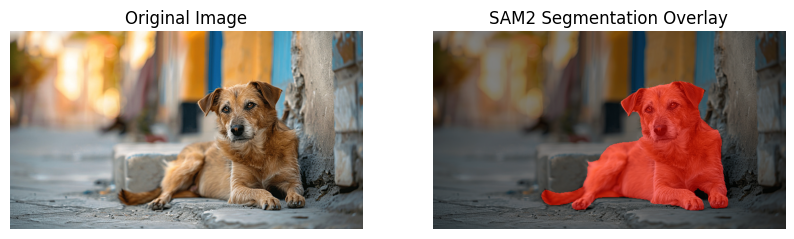

In [9]:
mask_overlay = np.zeros((image.height, image.width, 3), dtype=np.uint8)

for mask in final_masks:
    # (1, H, W) → (H, W)
    mask_arr = np.squeeze(mask.numpy()).astype(bool)

    # Apply red overlay
    color = np.array([255, 0, 0], dtype=np.uint8)
    mask_overlay[mask_arr] = color

# Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(mask_overlay, alpha=0.5)
plt.title("SAM2 Segmentation Overlay")
plt.axis('off')
plt.show()
